# CS4487 - Machine Learning
# Lecture 2b - Naive Bayes Classifier
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Naive Bayes Gaussian Classifier - Iris dataset
1. Naive Bayes Spam Classifier - Spam dataset

# Naive Bayes Classifier
- How to deal with multiple features?
  - e.g., $x = \begin{bmatrix}x_1\\x_2\end{bmatrix}$
- **Naive Bayes assumption**
  - assume each feature dimension is modeled independently.
    - e.g., for 2 dimensions, $p(x_1,x_2|y) = p(x_1|y)p(x_2|y)$
    - accumulates evidence from each feature dimension:
      - $\log p(x_1,x_2|y) = \log p(x_1|y)+\log p(x_2|y)$ 
  - allows us to model each dimension of the observation with a simple univariate distribution.
- **Example: Gaussian classifier**
  - We will consider the 2-dimensional iris data shown in the beginning of lecture.

# Setup Python

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)          # specify a seed so results are reproducible

# Load data

In [2]:
# define class labels, plot markers, and feature labels
markers   = ('ro', 'gs'); lines = ('r-', 'g-')
featnames = ("petal length", "sepal width")

# load iris dataset from scikit-learn
iris = datasets.load_iris()    

# get the indices of the 2 classes of interest.
# This is a boolean array that can select entries
inds = squeeze( (iris.target==1) | (iris.target==2) )

# get the targets (classes)
target   = iris.target[inds]
classnums  = unique(target)
classnames = ('versicolor (1)', 'virginica (2)')

# extract the data (each row is a sample)
# inds extracts rows, while
#  (2,1) extracts the two dimensions of interest
# ix_ is a magic function to select a subarray
data = iris.data[ix_(inds, (2,1))]
print data.shape

(100, 2)


# View data

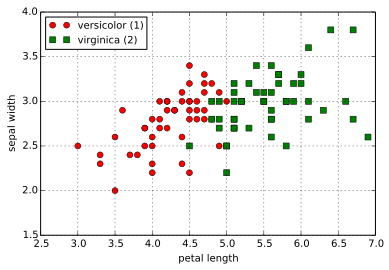

In [3]:
# start a new figure in matplotlib
plt.figure()   

# plot each class
for c in range(2):
    cli = squeeze(target==classnums[c])  # indices of this class
    plt.plot(data[cli,0], data[cli,1], markers[c])
# label the axes
plt.xlabel(featnames[0]); plt.ylabel(featnames[1])  
# add a legend
plt.legend(classnames, 0, framealpha=1, fontsize='medium')
# set plot axes; show grid
axbox = [2.5, 7, 1.5, 4]   # (xmin, xmax, ymin, ymax)
plt.axis(axbox); plt.grid(True);

# Split training/test data
- We will select 50% of the data for training, and 50% for testing
  - use `cross_validation` module

In [4]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  cross_validation.train_test_split(data, target, 
     train_size=0.5, test_size=0.5, random_state=4487)

print trainX.shape
print testX.shape

(50, 2)
(50, 2)


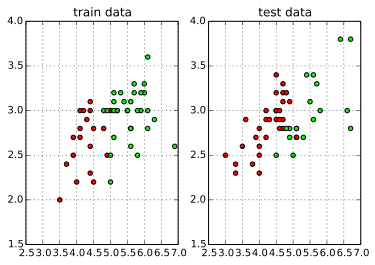

In [5]:
# view train & test data
plt.figure()
# make a colormap for viewing classes - range from red to white to green
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

plt.subplot(1,2,1)   # put two subplots in the same figure
# scatter plot - Y value selects the color 
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap)
plt.axis(axbox); plt.grid(True);
plt.title('train data')

plt.subplot(1,2,2)
plt.scatter(testX[:,0], testX[:,1], c=testY, cmap=mycmap )
plt.axis(axbox); plt.grid(True);
plt.title('test data');

# Learn Gaussian NB model
- treat each dimension as an independent Gaussian

In [6]:
# get the NB Gaussian model from sklearn
model = naive_bayes.GaussianNB()

# fit the model to training data
model.fit(trainX, trainY)

# see the parameters
print "class prior: " + str(model.class_prior_)
print "class 1 mean: " + str(model.theta_[0,:])
print "class 1 var:  " + str(model.sigma_[0,:])
print "class 2 mean: " + str(model.theta_[1,:])
print "class 2 var:  " + str(model.sigma_[1,:])

class prior: [ 0.38  0.62]
class 1 mean: [ 4.26842105  2.65789474]
class 1 var:  [ 0.14426593  0.09927978]
class 2 mean: [ 5.57741935  2.96451613]
class 2 var:  [ 0.22045786  0.07777315]


- View 2d class conditionals: 
  - $p(x_1,x_2|y=c)=p(x_1|y=c)p(x_2|y=c)$

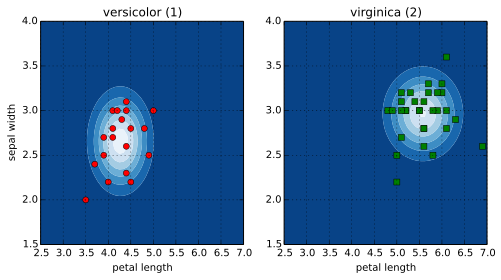

In [7]:
plt.figure(figsize=(8,4))  # set the figure size
# range for calculating plots
xr = [ linspace(axbox[0], axbox[1], 50), 
       linspace(axbox[2], axbox[3], 50) ]
for c in range(2):
    plt.subplot(1,2,c+1)
    # make a Gaussian pdf for each dimension (uses scipy.stats)
    pdf0 = stats.norm(loc=model.theta_[c,0],
                    scale=sqrt(model.sigma_[c,0]))
    pdf1 = stats.norm(loc=model.theta_[c,1],
                      scale=sqrt(model.sigma_[c,1]))   
    
    # calcuate the joint pdf (pdf0*pdf1)
    #   take outer product of pdfs from each dimension
    p = outer(pdf1.pdf(xr[1]), pdf0.pdf(xr[0]))
    
    # show contour plot of density
    plt.contourf(xr[0], xr[1], p, cmap=plt.get_cmap('Blues_r'))
    
    # show the training data
    cli = squeeze(trainY==classnums[c])
    plt.plot(trainX[cli,0], trainX[cli,1], markers[c])
    plt.title(classnames[c]); plt.xlabel(featnames[0])
    if(c==0): plt.ylabel(featnames[1])
    plt.axis(axbox); plt.grid(True);

# View the Posterior

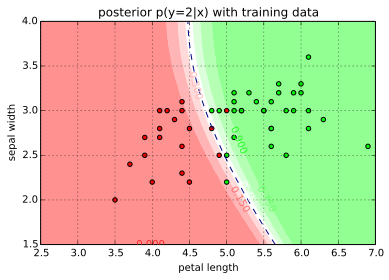

In [8]:
# make a grid for calculating the posterior, then form into a big [N,2] matrix
xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

# calculate the posterior probability
post = model.predict_proba(allpts)
# extract the posterior for class 2, and reshape into a grid
post1 = post[:,1].reshape(xgrid0.shape)

plt.figure()
# contour plot of the posterior
CS = plt.contourf(xr[0], xr[1], post1, cmap=mycmap, alpha=0.5)
plt.clabel(CS, inline=1, fontsize=10)
# show the decision boundary (p=0.5)
plt.contour(xr[0], xr[1], post1, levels=[0.5], linestyles='dashed')

# show training data
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap)
plt.axis(axbox); plt.grid(True);
plt.xlabel(featnames[0]); plt.ylabel(featnames[1])
plt.title('posterior p(y=2|x) with training data');

# Evaluate on the test set

In [9]:
# predict from the model
predY = model.predict(testX)

# calculate accuracy
Ncorrect = sum(testY==predY)
acc      = mean(testY==predY)
print Ncorrect
print "accuracy=" + str(acc)

42
accuracy=0.84


# Viewing test results

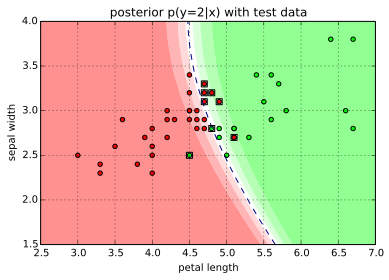

In [10]:
plt.figure()
# contour plot of the posterior and decision boundary
plt.contourf(xr[0], xr[1], post1, cmap=mycmap, alpha=0.5)
plt.contour(xr[0], xr[1], post1, levels=[0.5], linestyles='dashed')
# show the test data
plt.scatter(testX[:,0], testX[:,1], c=testY, cmap=mycmap)

# get test errors and mark them on the plot with a square
ni = where(testY!=predY)  # returns indices
plt.plot(testX[ni,0], testX[ni,1], 'ks', markeredgewidth=1, fillstyle='none')

plt.axis(axbox); plt.grid(True);
plt.xlabel(featnames[0]); plt.ylabel(featnames[1])
plt.title('posterior p(y=2|x) with test data');

# Example: Naive Bayes Spam Classifier
- Goal: given an input email, predict whether it is spam or not
  - input: text string
> A home based business opportunity is knocking at your door.
> DonÃ­t be rude and let this chance go by.
> You can earn a great income and find your financial life transformed.
> Learn more Here.
> To Your Success.
> Work From Home Finder Experts
  - output: spam, not spam (or ham)


# Text Document Representation
- Text document is a string!
  - we need to pick a suitable representation.
- **Bag-of-Words (BoW) model**
  - Let ${\cal V}=\{w_j\}_{j=1}^V$ be a list of $V$ words (called a **vocabulary**).
  - represent a text document as a vector $x\in{\mathbb R}^V$.
    - each entry $x_j$ represents the number of times word $w_j$ appears in the document.
- ** Example: **
  - Document: "This is a test document"
  - Vocabulary: ${\cal V} = \{\textrm{"this"}, \textrm{"test"}, \textrm{"spam"}, \textrm{"foo"}\}$
  - Vector representation: $x=[1, 1, 0, 0]$

- **NOTE:**
  - the order of the words is not used!
  - rearranging words leads to the same representation!
- Example: 
  - "this is spam"  $\rightarrow x=[1, 0, 1, 0]$
  - "is this spam" $\rightarrow x=[1, 0, 1, 0]$
- This is why it is called "bag-of-words"
![](lecture2/tom-mitchell-bow.jpg)
    

# Steps to make BoW
1. Build a vocabulary ${\cal V}$
  - remove _stopwords_
    - the most common words that provide little information
    - examples: "the", "a", "on"
  - _stemming_
    - convert related words into a common root word
    - examples: "testing" to "test", "tests" to "test"
  - convert to all lower case
2. Calculate the vector for each document
  - count the occurence of each word in the vocabulary

In [11]:
# Load text data from directories
#   each sub-directory contains text files for 1 class
textdata = datasets.load_files("lecture2/email", encoding="utf8", decode_error="replace")

# target names
print "class names = ", textdata.target_names
print "num samples=" + str(len(textdata.target))

class names =  ['ham', 'spam']
num samples=50


In [12]:
# look at first sample
print "Sample 1 is Class " + str(textdata.target[0]) + \
  "(" + textdata.target_names[textdata.target[0]] + ")"
print "---"
print textdata.data[0]

Sample 1 is Class 1(spam)
---
Get Up to 75% OFF at Online WatchesStore

Discount Watches for All Famous Brands

* Watches: aRolexBvlgari, Dior, Hermes, Oris, Cartier, AP and more brands
* Louis Vuitton Bags & Wallets
* Gucci Bags
* Tiffany & Co Jewerly

Enjoy a full 1 year WARRANTY
Shipment via reputable courier: FEDEX, UPS, DHL and EMS Speedpost
You will 100% recieve your order


In [13]:
# randomly split data into 50% train and 50% test set
traintext, testtext, trainY, testY = \
  cross_validation.train_test_split(textdata.data, textdata.target, 
  train_size=0.5, test_size=0.5, random_state=11)

print len(traintext)
print len(testtext)

25
25


In [14]:
# setup the document vectorizer
# - use english stop words
# - only use the most frequent 100 words in the dataset
cntvect = feature_extraction.text.CountVectorizer(stop_words='english', max_features=100)

# create the vocabulary, and return the document vectors
# NOTE: we only use the training data!
trainX = cntvect.fit_transform(traintext)

# calculate vectors for the test data
testX  = cntvect.transform(testtext)

# print the vocabulary
# - (key,value) pairs correspond to (word,vector index)
print cntvect.vocabulary_

{u'code': 22, u'send': 85, u'details': 33, u'risk': 82, u'mg': 60, u'choice': 20, u'ryan': 83, u'cost': 27, u'current': 29, u'mr': 63, u'let': 55, u'address': 12, u'30': 7, u'names': 64, u'today': 91, u'phone': 71, u'account': 11, u'scifinance': 84, u'following': 39, u'states': 88, u'united': 92, u'inheritance': 50, u'provide': 74, u'brand': 18, u'information': 49, u'inform': 48, u'chief': 19, u'office': 69, u'soon': 86, u'20': 5, u'interesting': 51, u'2010': 6, u'day': 31, u'bank': 16, u'status': 89, u'financial': 38, u'funds': 44, u'pills': 72, u'working': 98, u'frank': 41, u'agaliofu': 14, u'york': 99, u'days': 32, u'david': 30, u'major': 56, u'number': 68, u'gpu': 46, u'nigeria': 67, u'man': 58, u'forward': 40, u'regards': 76, u'10': 2, u'john': 52, u'enabled': 35, u'nations': 65, u'compensation': 25, u'wilmott': 95, u'wilson': 96, u'new': 66, u'70': 10, u'microsoft': 61, u'going': 45, u'120': 3, u'watson': 93, u'freeviagra': 42, u'release': 77, u'close': 21, u'00': 0, u'federal': 

In [15]:
# show a document vector
# - only the non-zero entries are printed
print trainX[0]

  (0, 31)	2
  (0, 63)	2
  (0, 52)	2
  (0, 41)	2
  (0, 92)	2
  (0, 65)	1
  (0, 78)	1
  (0, 88)	1
  (0, 70)	5
  (0, 16)	1
  (0, 50)	1
  (0, 74)	1
  (0, 47)	1
  (0, 64)	1
  (0, 26)	2
  (0, 71)	1
  (0, 68)	1
  (0, 12)	1
  (0, 49)	1
  (0, 80)	1
  (0, 44)	1
  (0, 40)	1


In [16]:
# show the words
mywords = [key for (key, value) in cntvect.vocabulary_.iteritems() 
             if (trainX[0,value]>0)]
print mywords
print "---"
print traintext[0]

[u'mr', u'address', u'names', u'phone', u'states', u'united', u'inheritance', u'provide', u'information', u'day', u'bank', u'funds', u'frank', u'number', u'forward', u'john', u'nations', u'representative', u'contact', u'payment', u'info', u'required']
---
Attn:Good Day,

Compliment of the day to you, my name is Mr John Frank Harmon a UNITED
NATIONS Representative here in UNITED STATES this year 2014 last
payment quarter for all outstanding payment from World Bank on overdue
contracts,inheritance and all other payment has commenced,you are to
provide the below info asap so that the payment processing can start
off.

Your full names
Contact phone number
Contact Address

The above information is required so as to go through your payment
file and start the processing of this long and overdue funds.

looking forward to hearing from you

Mr John Frank Harmon


# Naive Bayes model for Boolean vectors
- Model each word independently
  - absence/presence of a word $w_j$ in document
  - Bernoulli distribution
    - present: $p(x_j=1|y) = \pi_j$
    - absent: $p(x_j=0|y) = 1-\pi_j$
  - MLE parameters: $\pi_j=N_j/N$, 
    - $N_j$ is the number of documents in class $y$ that contain word $j$.
    - $N$ is the number of documents in class $y$.

- Class-conditional distribution
   $$p(x_1,\cdots,x_V|y=\textrm{spam}) = \prod_{j=1}^V p(x_j|y=\textrm{spam})$$
   $$\log p(x_1,\cdots,x_V|y=\textrm{spam}) = \sum_{j=1}^V \log p(x_j|y=\textrm{spam})$$
- for a document, the log-probabilities of the words being in a spam message adds.
  - accumulate evidence over all words in the document.
  - more words that are associated with spam --> more likely the document is spam

/Library/Python/2.7/site-packages/sklearn/naive_bayes.py:707: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)


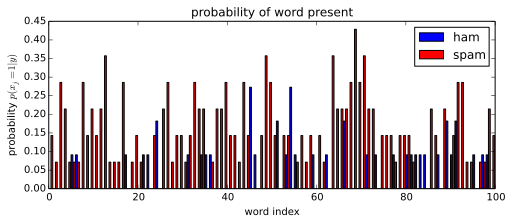

In [17]:
# fit the NB Bernoulli model.
# the model automatically converts count vector into binary vector
bmodel = naive_bayes.BernoulliNB(alpha=0.0)
bmodel.fit(trainX, trainY)

# show the probabilities for each class
xr = arange(0,len(cntvect.vocabulary_))
plt.figure(figsize=(8,3))
a1 = plt.bar(xr, exp(bmodel.feature_log_prob_[0,:]), width=0.4)   # not-spam
a2 = plt.bar(xr+0.5, exp(bmodel.feature_log_prob_[1,:]), width=0.4, color='r')  # spam
plt.legend((a1,a2), textdata.target_names)
plt.xlabel('word index'); plt.ylabel('probability $p(x_j=1|y)$');
plt.title('probability of word present')

In [18]:
# prediction
predY = bmodel.predict(testX)
print "predictions: ", predY
print "actual:      ", testY

# calculate accuracy
acc = mean(predY==testY)
print acc

predictions:  [0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0]
actual:       [0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1]
0.64


# Smoothing
- Some words are not present in any documents for a given class.
  - $N_j=0$, and thus $\pi_j = 0$.
    - i.e., the document in the class **definitely** will not contain the word.
    - can be a problem since we simply may not have seem an example with that word.
- Smoothed MLE
  - add a smoothing parameter $\alpha$ that adds a "virtual" count
  - parameter: $\pi_j= (N_j+\alpha)/(N+2\alpha)$, 
  - this is called _Laplace smoothing_
- In general, _regularizing_ or _smoothing_ of the estimate helps to prevent _overfitting_ of the parameters.

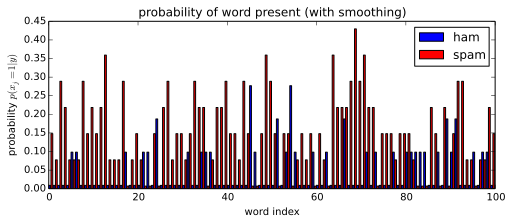

In [19]:
# fit the NB Bernoulli model w/ smoothing (0.1)
bmodel = naive_bayes.BernoulliNB(alpha=0.1)
bmodel.fit(trainX, trainY)

# show the probabilities for each class
plt.figure(figsize=(8,3))
a1 = plt.bar(xr, exp(bmodel.feature_log_prob_[0,:]), width=0.4)
a2 = plt.bar(xr+0.5, exp(bmodel.feature_log_prob_[1,:]), width=0.4, color='r')
plt.legend((a1,a2), textdata.target_names)
plt.xlabel('word index'); plt.ylabel('probability $p(x_j=1|y)$');
plt.title('probability of word present (with smoothing)')
# note the small probabilities are all slightly above 0.

In [20]:
# prediction
predY = bmodel.predict(testX)
print "predictions: ", predY
print "actual:      ", testY

# calculate accuracy
acc = mean(predY==testY)
print acc  
# a little better!

predictions:  [0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1]
actual:       [0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1]
0.72


# Most informative words
- The most informative words are those with high probability of being in one class, and low probability of being in other classes.
  - e.g., For class 1, find large values of $\log p(w_j|y=1) - \log p(w_j|y=0)$

In [21]:
# get the word names
fnames = asarray(cntvect.get_feature_names())
# coef_ contains the scores for each word
# (higher means more informative)
# sort the coefficients in ascending order, and take the 10 largest.
tmp = argsort(bmodel.coef_[0])[-10:]
print "top 10 indices: ", tmp
print "coefficients:   ", bmodel.coef_[0,tmp]
print "words:          ", fnames[tmp]

top 10 indices:  [16 67 26 69 32 48 70 63 12 68]
coefficients:    [-1.24225499 -1.24225499 -1.24225499 -1.24225499 -1.24225499 -1.02400142
 -1.02400142 -1.02400142 -1.02400142 -0.84495319]
words:           [u'bank' u'nigeria' u'contact' u'office' u'days' u'inform' u'payment' u'mr'
 u'address' u'number']


# Naive Bayes for Count Vectors
- Now we consider using the number of times each word appears in the document $D$.
- Two ways to create a document vector $x$ based on the word counts.

- **Term-Frequency (TF)**
  - handles documents with different lengths (number of words).
  - normalize the count to a frequency, by dividing by the number of words in the document.
    - $x_j = \frac{w_j}{|D|}$
      - $w_j$ is the number of times word $j$ appears in the document
      - $|D|$ is the number of words in the document.

- **Term-Frequency Inverse Document Frequency (TF-IDF)**
  - some words are common among many documents
    - common words are less informative because they appear in both classes.
  - **inverse document frequency (IDF)** - measure rarity of each word
    - $IDF(j) = \log \frac{N}{N_j}$
      - $N$ is the number of documents.
      - $N_j$ is the number of documents with word $j$.
    - IDF is:
      - 0 when a word is common to all documents
      - large value when the word appears in few documents
  - **TF-IDF vector:** downscale words that are common in many documents
    - multiply TF and IDF terms
    - $x_j = \frac{w_j}{|D|} \log \frac{N}{N_j}$

In [22]:
# TF-IDF representation
# (For TF, pass use_idf=False)
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True)

# setup the TF-IDF representation, and transform the training set
trainXtf = tf_trans.fit_transform(trainX)

# transform the test set
testXtf = tf_trans.transform(testX)

print trainXtf[0]

  (0, 40)	0.145622966019
  (0, 44)	0.145622966019
  (0, 80)	0.132363486511
  (0, 49)	0.122078635179
  (0, 12)	0.113675299769
  (0, 68)	0.106570380916
  (0, 71)	0.122078635179
  (0, 26)	0.244157270358
  (0, 64)	0.132363486511
  (0, 47)	0.145622966019
  (0, 74)	0.145622966019
  (0, 50)	0.145622966019
  (0, 16)	0.122078635179
  (0, 70)	0.568376498846
  (0, 88)	0.132363486511
  (0, 78)	0.145622966019
  (0, 65)	0.132363486511
  (0, 92)	0.244157270358
  (0, 41)	0.291245932039
  (0, 52)	0.291245932039
  (0, 63)	0.227350599538
  (0, 31)	0.264726973022


# Naive Bayes Multinomial
- TF or TF-IDF representation
  - Document word vector $x$
    - $x_j$ is the frequency of word $j$ occuring in the document.
    - vector $x$ sums to 1, i.e. $\sum_{j} x_j = 1$.
- Use a multinomial distribution as the class conditional
  - based on the frequency that a word appears in a document of a class.

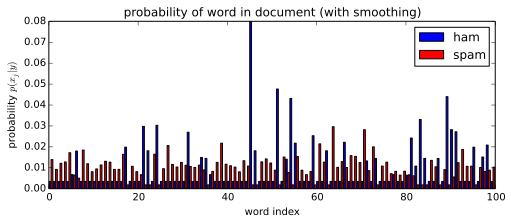

In [23]:
# fit a multinomial model (with smoothing)
mmodel_tf = naive_bayes.MultinomialNB(alpha=0.1)
mmodel_tf.fit(trainXtf, trainY)

# show the word probabilites
plt.figure(figsize=(8,3))
a1 = plt.bar(xr, exp(mmodel_tf.feature_log_prob_[0,:]), width=0.4)
a2 = plt.bar(xr+0.5, exp(mmodel_tf.feature_log_prob_[1,:]), width=0.4, color='r')
plt.legend((a1,a2), textdata.target_names)
plt.xlabel('word index'); plt.ylabel('probability $p(x_j|y)$');
plt.title('probability of word in document (with smoothing)');

In [24]:
# prediction
predYtf = mmodel_tf.predict(testXtf)
print "prediction: ", predYtf
print "actual:     ", testY

# calculate accuracy
acc = mean(predYtf==testY)
print acc  

prediction:  [0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1]
actual:      [0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1]
0.68


In [25]:
# most informative words for TF-IDF
fnames = asarray(cntvect.get_feature_names())
tmp = argsort(mmodel_tf.coef_[0])[-10:]
print tmp
print fnames[tmp]

[23  4  7 92 72 26 60 38 70 63]
[u'codeine' u'15mg' u'30' u'united' u'pills' u'contact' u'mg' u'financial'
 u'payment' u'mr']


# Summary
- **Generative classification model**
  - estimate probability distributions of features generated from each class.
  - given feature observation predict class with largest posterior probability.
- **Advantages:**
  - works with small amount of data.
  - works with multiple classes.
- **Disadvantages:**
  - accuracy depends on selecting an appropriate probability distribution.
    - if the probability distribution doesn't model the data well, then accuracy might be bad.